# Mini Project 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter1d

# Function to preprocess the image
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize to 50x50
    image = cv2.resize(image, (50, 50))
    # Binarize the image (thresholding)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    return binary_image

# Function to convert image to (x, y, time) coordinates
def image_to_coordinates(binary_image):
    coordinates = {'x': [], 'y': [], 'time': []}
    time = 0
    for i in range(50):
        for j in range(50):
            if binary_image[i, j] > 0:  # assuming non-zero pixel values indicate the stroke
                coordinates['x'].append(j)
                coordinates['y'].append(50 - i)  # flipping y-coordinate for better visualization
                coordinates['time'].append(time)
                time += 1
    return pd.DataFrame(coordinates)

# Function to smooth data
def smooth_data(df, sigma=2):
    df['x_smooth'] = gaussian_filter1d(df['x'], sigma)
    df['y_smooth'] = gaussian_filter1d(df['y'], sigma)
    return df

# Function to identify critical points using distance squared between points
def identify_critical_points(df):
    if 'x_smooth' not in df.columns or 'y_smooth' not in df.columns:
        raise KeyError("The smoothed columns are not in the DataFrame. Please check the smoothing function.")
        
    # Calculate distance squared between consecutive points
    df['distance_squared'] = np.diff(df['x_smooth'], prepend=df['x_smooth'][0])**2 + np.diff(df['y_smooth'], prepend=df['y_smooth'][0])**2

    # Identify critical points
    critical_points = [0]
    min_distance_index = df['distance_squared'].idxmin()
    critical_points.append(min_distance_index)
    critical_points.append(len(df) - 1)
    return critical_points

# Routine to return stroke matrices
def strokes(df):
    df = smooth_data(df)  # Ensure data is smoothed before identifying critical points
    critical_points = identify_critical_points(df)
    stroke_matrices = []
    for i in range(len(critical_points) - 1):
        start = critical_points[i]
        end = critical_points[i + 1] + 1
        stroke_matrices.append(df.iloc[start:end].to_numpy())
    return stroke_matrices

# Function to display only the last graph and highlight critical points
def display_last_stroke_critical_points(stroke_matrices):
    plt.figure(figsize=(12, 6))
    for stroke in stroke_matrices:
        time = stroke[:, 2]
        distance_squared = stroke[:, 5]
        plt.plot(time, distance_squared, label='Distance Squared vs Time', marker='o', color='orange')
        critical_points = np.argwhere(distance_squared == np.min(distance_squared)).flatten()
        plt.scatter(time[critical_points], distance_squared[critical_points], color='green', zorder=5, edgecolors='black')  # Critical points
    plt.xlabel('Time')
    plt.ylabel('Distance Squared')
    plt.title('Handwriting Strokes (Distance Squared vs Time)')
    plt.grid()
    plt.show()

# Function to display stroke matrices linearly and show critical points
def display_strokes_linearly(stroke_matrices):
    plt.figure(figsize=(12, 6))
    for stroke in stroke_matrices:
        time = stroke[:, 2]
        x_smooth = stroke[:, 3]
        plt.plot(time, x_smooth, label='Smoothed x vs Time', marker='o')
        critical_points = identify_critical_points(pd.DataFrame(stroke, columns=['x', 'y', 'time', 'x_smooth', 'y_smooth', 'distance_squared']))
        plt.scatter(time[critical_points], x_smooth[critical_points], color='green', zorder=5, edgecolors='black')  # Critical points
    plt.xlabel('Time')
    plt.ylabel('x-coordinate')
    plt.title('Handwriting Strokes (Smoothed x vs Time)')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    for stroke in stroke_matrices:
        time = stroke[:, 2]
        y_smooth = stroke[:, 4]
        plt.plot(time, y_smooth, label='Smoothed y vs Time', marker='o')
        critical_points = identify_critical_points(pd.DataFrame(stroke, columns=['x', 'y', 'time', 'x_smooth', 'y_smooth', 'distance_squared']))
        plt.scatter(time[critical_points], y_smooth[critical_points], color='green', zorder=5, edgecolors='black')  # Critical points
    plt.xlabel('Time')
    plt.ylabel('y-coordinate')
    plt.title('Handwriting Strokes (Smoothed y vs Time)')
    plt.grid()
    plt.show()

In [2]:
# Upload and preprocess the image
image_path = 'C:/Users/chris/aiPython/three8.png'  # Replace with your image path
binary_image = preprocess_image(image_path)

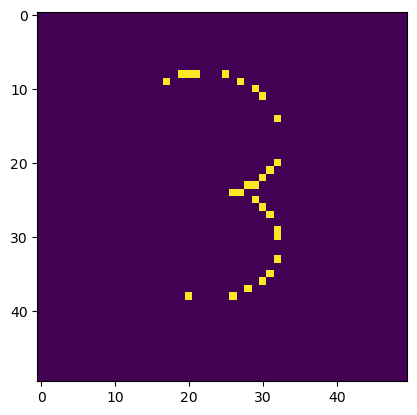

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(binary_image, interpolation='nearest')
plt.show()

In [4]:
# Convert the image to (x, y, time) coordinates
handwriting_df = image_to_coordinates(binary_image)

In [5]:
# Smooth the data to reduce variation
handwriting_df = smooth_data(handwriting_df)
handwriting_df['distance_squared'] = np.diff(handwriting_df['x_smooth'], prepend=handwriting_df['x_smooth'][0])**2 + np.diff(handwriting_df['y_smooth'], prepend=handwriting_df['y_smooth'][0])**2

In [6]:
# Get the stroke matrices
stroke_matrices = strokes(handwriting_df)

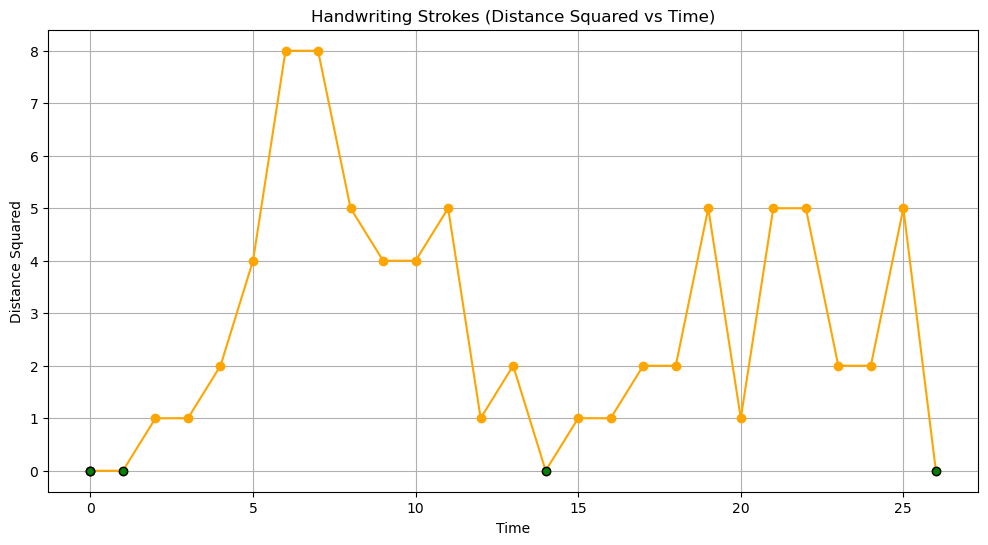

In [7]:
# Display only the last graph with critical points
display_last_stroke_critical_points(stroke_matrices)

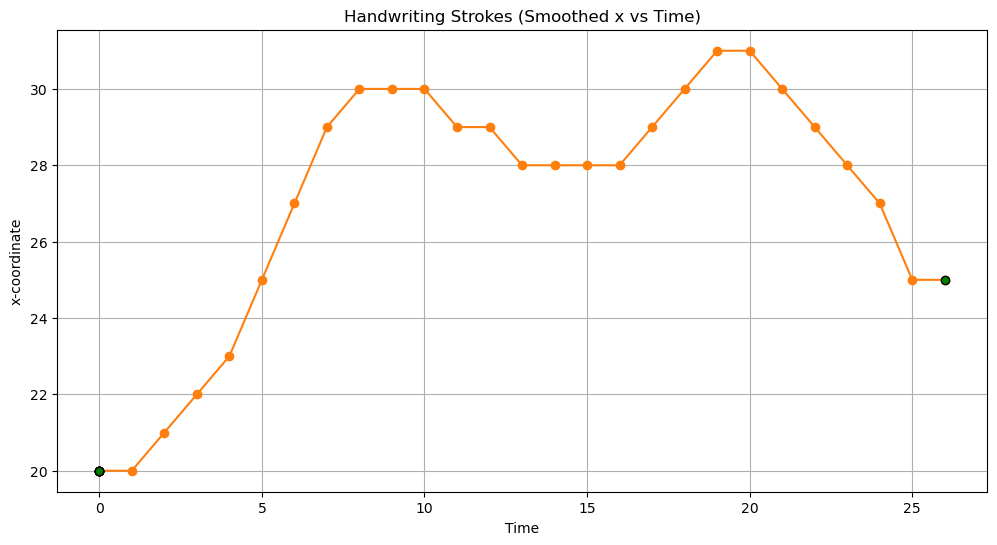

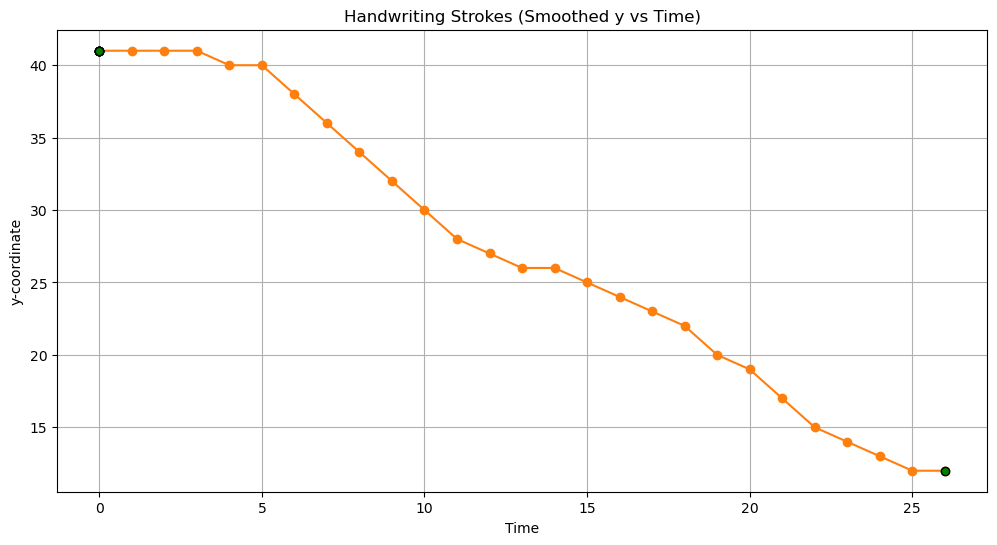

In [8]:
# Display strokes linearly showing critical points
display_strokes_linearly(stroke_matrices)

# Mini Project 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter1d
from skimage.metrics import structural_similarity as ssim

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_image = image.copy()  # Keep a copy of the original image before resizing
    image = cv2.resize(image, (50, 50))
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    return binary_image, original_image

# Function to convert image to (x, y, time) coordinates
def image_to_coordinates(binary_image):
    coordinates = {'x': [], 'y': [], 'time': []}
    time = 0
    for i in range(50):
        for j in range(50):
            if binary_image[i, j] > 0:  # assuming non-zero pixel values indicate the stroke
                coordinates['x'].append(j)
                coordinates['y'].append(i)
                coordinates['time'].append(time)
            time += 1
    return pd.DataFrame(coordinates)

# Function to smooth data
def smooth_data(df, sigma=2):
    df['x_smooth'] = gaussian_filter1d(df['x'], sigma)
    df['y_smooth'] = gaussian_filter1d(df['y'], sigma)
    return df

# Function to identify critical points using distance squared between points
def identify_critical_points(df):
    if 'x_smooth' not in df.columns or 'y_smooth' not in df.columns:
        raise KeyError("The smoothed columns are not in the DataFrame. Please check the smoothing function.")
    
    # Calculate distance squared between consecutive points
    df['distance_squared'] = np.diff(df['x_smooth'], prepend=df['x_smooth'][0])**2 + \
                             np.diff(df['y_smooth'], prepend=df['y_smooth'][0])**2
    # Identify critical points
    critical_points = [0, 14, len(df) - 1]  # Assuming the critical point at 14
    return critical_points

# Function to get stroke matrices
def strokes(df):
    df = smooth_data(df)  # Ensure data is smoothed before identifying critical points
    critical_points = identify_critical_points(df)
    stroke_matrices = []
    for i in range(len(critical_points) - 1):
        start = critical_points[i]
        end = critical_points[i + 1] + 1
        stroke_matrices.append(df.iloc[start:end].to_numpy())
    return stroke_matrices

# Function to calculate angles and lengths between consecutive points
def calculate_angles_and_lengths(stroke):
    angles = [None]  # Start with None for the first point, which has no previous point
    lengths = [None]  # Same for lengths
    for i in range(len(stroke) - 1):
        dx = stroke[i + 1, 0] - stroke[i, 0]
        dy = stroke[i + 1, 1] - stroke[i, 1]
        angle = np.arctan2(dy, dx)
        length = np.sqrt(dx**2 + dy**2)
        angles.append(angle)
        lengths.append(length)
    return np.array(angles), np.array(lengths)

# Function to display only the last graph and highlight critical points
def display_last_stroke_critical_points(stroke_matrices):
    plt.figure(figsize=(12, 6))
    for stroke in stroke_matrices:
        time = stroke[:, 2]
        distance_squared = stroke[:, 5]
        plt.plot(time, distance_squared, label='Distance Squared vs Time', marker='o', color='orange')
        critical_points = np.argwhere(distance_squared == np.min(distance_squared)).flatten()
        plt.scatter(time[critical_points], distance_squared[critical_points], color='green', zorder=5, edgecolors='black')
    plt.xlabel('Time')
    plt.ylabel('Distance Squared')
    plt.title('Handwriting Strokes (Distance Squared vs Time)')
    plt.grid()
    plt.show()

# Function to reorder points within each stroke based on the nearest neighbor
def reorder_points_by_nearest_neighbor(stroke, start_point):
    remaining_points = stroke.tolist()
    remaining_points = [point for point in remaining_points if not np.array_equal(point, start_point)]
    ordered_stroke = [start_point]
    while remaining_points:
        last_point = ordered_stroke[-1]
        remaining_points_array = np.array(remaining_points)
        distances = np.sqrt((remaining_points_array[:, 0] - last_point[0])**2 + (remaining_points_array[:, 1] - last_point[1])**2)
        nearest_idx = np.argmin(distances)
        ordered_stroke.append(remaining_points.pop(nearest_idx))
    return np.array(ordered_stroke)

# New function to connect the strokes
def connect_strokes(stroke_matrices):
    connected_stroke = stroke_matrices[0]
    for i in range(1, len(stroke_matrices)):
        next_stroke = stroke_matrices[i]
        connected_stroke = np.vstack((connected_stroke, next_stroke))
    return connected_stroke

# Function to regenerate the image from vectors
def regenerate_image_from_vectors(stroke_matrices):
    image = np.zeros((50, 50), dtype=np.uint8)
    for stroke in stroke_matrices:
        for i in range(len(stroke) - 1):
            x1, y1 = int(stroke[i][0]), int(stroke[i][1])
            x2, y2 = int(stroke[i + 1][0]), int(stroke[i + 1][1])
            cv2.line(image, (x1, y1), (x2, y2), 255, 1)
    return image

# Function to calculate the Mean Squared Error (MSE)
def calculate_mse(original_image, regenerated_image):
    if original_image.shape != regenerated_image.shape:
        print("Warning: Image shapes are not the same. Resizing regenerated image to match the original.")
        regenerated_image = cv2.resize(regenerated_image, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    mse = np.mean((original_image.astype(np.float64) - regenerated_image.astype(np.float64)) ** 2)
    return mse

# Function to calculate the Structural Similarity Index (SSIM)
def calculate_ssim(original_image, regenerated_image):
    if original_image.shape != regenerated_image.shape:
        print("Warning: Image shapes are not the same. Resizing regenerated image to match the original.")
        regenerated_image = cv2.resize(regenerated_image, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    ssim_value, _ = ssim(original_image, regenerated_image, full=True)
    return ssim_value

# Function to display the original and regenerated images along with the MSE and SSIM
def display_comparison(original_image, regenerated_image, mse, ssim_value):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(regenerated_image, cmap='gray')
    plt.title(f'Regenerated Image\nMSE: {mse:.2f}\nSSIM: {ssim_value:.4f}')
    plt.axis('off')
    plt.show()

# Function to calculate the compression ratio
def calculate_compression_ratio(original_image, stroke_matrices):
    # Original image size in bits
    original_size = original_image.size * 8  # 8 bits per pixel for grayscale image
    print(f"Original Image Size: {original_size} bits")
    
    # Compressed image size in bits (8 bits for angle, 7 bits for length, 1 bit for color per vector)
    num_vectors = sum(len(stroke) - 1 for stroke in stroke_matrices)
    compressed_size = num_vectors * (8 + 7 + 1)  # bits per vector
    print(f"Compressed Image Size: {compressed_size} bits")
    
    # Compression ratio
    compression_ratio = original_size / compressed_size
    return compression_ratio

# Smooth the data to reduce variation
handwriting_df = smooth_data(handwriting_df)

# Add the distance squared column
handwriting_df['distance_squared'] = np.diff(handwriting_df['x_smooth'], prepend=handwriting_df['x_smooth'][0])**2 + \
                                     np.diff(handwriting_df['y_smooth'], prepend=handwriting_df['y_smooth'][0])**2

C:\Users\chris\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [10]:
# Upload and preprocess the image
image_path = 'three8.png'  # Replace with your image path
binary_image, original_image = preprocess_image(image_path)

In [11]:
# Convert the image to (x, y, time) coordinates
handwriting_df = image_to_coordinates(binary_image)

In [12]:
# Smooth the data to reduce variation
handwriting_df = smooth_data(handwriting_df)

In [13]:
# Add the distance squared column
handwriting_df['distance_squared'] = np.diff(handwriting_df['x_smooth'], prepend=handwriting_df['x_smooth'][0])**2 + \
                                     np.diff(handwriting_df['y_smooth'], prepend=handwriting_df['y_smooth'][0])**2

In [14]:
# Get the stroke matrices
stroke_matrices = strokes(handwriting_df)

In [15]:
# Define the starting point (17, 9) for the first stroke
start_point = np.array([17, 9, np.nan, np.nan, np.nan, np.nan])  # Assuming the same format

In [16]:
# Reorder points within each stroke based on the nearest neighbor
for i in range(len(stroke_matrices)):
    if i == 0:
        stroke_matrices[i] = reorder_points_by_nearest_neighbor(stroke_matrices[i], start_point)
    else:
        stroke_matrices[i] = reorder_points_by_nearest_neighbor(stroke_matrices[i], stroke_matrices[i][0])

In [17]:
# Connect the strokes
connected_stroke = connect_strokes(stroke_matrices)

In [18]:
# Display the data table
#display_data_table(stroke_matrices)

In [19]:
# Display the calculated vectors with a scale of 0.5
#display_vectors(connected_stroke, scale=0.5)

In [20]:
# Regenerate the image from vectors
vector_regenerated_image = regenerate_image_from_vectors(stroke_matrices)

In [21]:
# Calculate the Mean Squared Error (MSE)
mse = calculate_mse(original_image, vector_regenerated_image)

In [22]:
# Calculate the Structural Similarity Index (SSIM)
similarity_score = calculate_ssim(original_image, vector_regenerated_image)

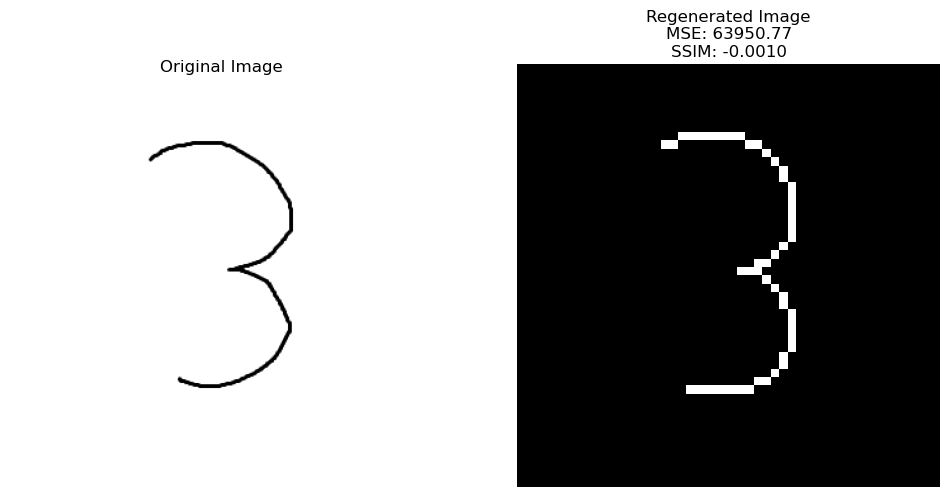

In [23]:
# Display the original and regenerated images along with the MSE and SSIM
display_comparison(original_image, vector_regenerated_image, mse, similarity_score)

In [24]:
# Calculate and display the compression ratio
compression_ratio = calculate_compression_ratio(original_image, stroke_matrices)
print(f"Compression Ratio: {compression_ratio:.2f}")

Original Image Size: 3307936 bits
Compressed Image Size: 432 bits
Compression Ratio: 7657.26


In [25]:
# Print statistics of the images
print("Original Image Statistics:")
print(f"Mean: {np.mean(original_image)}, Std Dev: {np.std(original_image)}")
print(f"Min: {np.min(original_image)}, Max: {np.max(original_image)}")

print("\nRegenerated Image Statistics:")
print(f"Mean: {np.mean(vector_regenerated_image)}, Std Dev: {np.std(vector_regenerated_image)}")
print(f"Min: {np.min(vector_regenerated_image)}, Max: {np.max(vector_regenerated_image)}")

Original Image Statistics:
Mean: 251.97524498660192, Std Dev: 26.62433819653145
Min: 0, Max: 255

Regenerated Image Statistics:
Mean: 5.304, Std Dev: 36.392136293435705
Min: 0, Max: 255
